# ChatBot with Rasa
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaX3LNhGcAe1HnPZSuWS0oH6af0LJHXcH7If1sQgLCFAT1chNGFg)


## Abstract

Chatbots, or conversational interfaces as they are also known, present a new way for individuals to interact with computer systems. Traditionally, to get a question answered by a software program involved using a search engine, or filling out a form. A chatbot allows a user to simply ask questions in the same manner that they would address a human. The most well known chatbots currently are voice chatbots: Alexa and Siri. However, chatbots are currently being adopted at a high rate on computer chat platforms.

The technology at the core of the rise of the chatbot is natural language processing (“NLP”). Recent advances in machine learning have greatly improved the accuracy and effectiveness of natural language processing, making chatbots a viable option for many organizations. This improvement in NLP is firing a great deal of additional research which should lead to continued improvement in the effectiveness of chatbots in the years to come.

We will be evaluating different chatbots first and creating a chatbot. Goal is to integrate any website with a chatbot. Objective is that it is domain specific for now, can be extended to be scalable across other platforms. We will use RASA NLU to understand the questions in a correct manner and also take care of foul language being used. We will use intent classification and entity extraction.

## What is Rasa NLU?

Rasa NLU is an open source NLP library for intent classification and entity extraction. You can think of it as a set of high-level APIs for building your own language parser using existing NLP and ML libraries.

## Why Rasa NLU?

1. We don’t have to hand over all your training data to Google, Microsoft, Amazon, or Facebook.
2. Machine Learning is not one-size-fits all. You can tweak and customize models for your training data.
3. Rasa NLU runs wherever we want, so we don’t have to make an extra network request for every message that comes in.

Steps to Install and Run Rasa ChatBot
*   Part 0: Installation and setup
*   Part 1: Teaching the chatbot to understand user inputs using Rasa NLU model
*   Part 2: Teaching the chatbot to handle multi-turn conversations using dialogue management model.
*   Part 3: Resources and tips

## Part 0: Installation

### Let's start with jupyter configuration

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Installation of Rasa
Let's start with the installation of Rasa NLU, Rasa Core and a spacy language model. If you have already installed, you can skip this step. 

import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.6 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md
!{python} -m spacy link en_core_web_md en --force;

Let's test the installation - we should have rasa_nlu: 0.12.3 and rasa_core: 0.9.6 installed, and spacy model should be available.

In [2]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Enabled"))

rasa_nlu: 0.12.3 rasa_core: 0.9.6
Loading spaCy language model...
Enabled


In [3]:
import spacy
print(spacy.__version__)

2.0.18


## Part 1: Natural Language Understanding

At first, let's teach our chatbot how to understand user inputs. To do that, we are going to build a Rasa NLU model. Here is some data to get started:  

**Conversation_1:**   
U: Hello  
B: Hello, how are you doing?  
U: I am doing great!  
B: Great. Carry on!  
    
**Conversation_2:**  
U: Hey  
B: Hello, how are you doing?  
U: I am very sad  
B: To cheer you up, I can show you a cute picture of a cat, a dog or a bird. Choose one :)  
U: A kitten  
B: Here is something to cheer you up. Did that help?  
U: Yes  
B: Goodbye  
  
**Conversation_3:**    
U: Heya  
B: Hello, how are you doing?  
U: Not so good and the only thing that could help me feel better is a picture of a puppy  
B: Here is something to cheer you up. Did that help?  
U: No  
B: Goodbye  
U: Bye  

### Creating the training data for language understanding model


Lets create some training data here, grouping user messages by their `intents`. The intent describes what the messages *mean*. Another important part of training data are `entities` - pieces of information which help a chatbot understand what specifically a user is asking about. Entities are labeled using the markdown link syntex: `[entity value](entity_type)` [More information about the data format](https://nlu.rasa.com/dataformat.html#markdown-format).

In [4]:
nlu_md = """
## intent:greet
- hey
- hello there
- hi
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:introduction
- tell me about your personality
- why are you here
- talk about yourself
- tell me some stuff about you
- talk some stuff about yourself
- I want to know you better
- I want to know more about you
- who are you
- tell me about yourself
- tell me about you
- about yourself
- describe yourself
- introduce yourself
- say about you
- what are you
- define yourself
- what is your personality
- all about you

## intent:age
- tell me your age
- what's your age
- your age
- age of yours
- how old are you
- I'd like to know your age
- are you 21 years old
- how old is your platform

## intent:annoying
- you are annoying me so much
- you're incredibly annoying
- I find you annoying
- you are annoying
- you're so annoying
- how annoying you are
- you annoy me
- you are annoying me
- you are irritating
- you are such annoying
- you're too annoying
- you are very annoying

## intent:answer_question
- I want you to answer me
- answer
- answer my question
- answer me
- give me an answer
- answer the question
- can you answer my question
- tell me the answer
- answer it
- give me the answer
- I have a question
- I want you to answer my question
- just answer the question
- can you answer me
- answers
- can you answer a question for me
- can you answer
- answering questions
- I want the answer now
- just answer my question

## intent:unhelpful
- you're not helping me
- you are bad
- you're very bad
- you're really bad
- you are useless
- you are horrible
- you are a waste of time
- you are disgusting
- you are lame
- you are no good
- you're bad
- you're awful
- you are not cool
- you are not good
- you are so bad
- you are so useless
- you are terrible
- you are totally useless
- you are very bad
- you are waste
- you're a bad
- you're not a good
- you're not very good
- you're terrible
- you're the worst
- you're the worst ever
- you're worthless

## intent:smart
- study
- you should study better
- you must learn
- be clever
- be more clever
- be smarter
- be smart
- get qualified

## intent:beautiful
- you're cute
- you're attractive
- you are beautiful
- you're looking good today
- you are so beautiful
- you look amazing
- you look so good
- you're so gorgeous
- you are too beautiful
- you look great
- you look so well
- I like the way you look now
- I think you're beautiful
- why are you so beautiful
- you are so beautiful to me
- you are cute
- you are gorgeous
- you are handsome
- you are looking awesome
- you look amazing today
- you are looking beautiful today
- you are looking great
- you are looking pretty
- you are looking so beautiful
- you are looking so good
- you are pretty
- you are really beautiful
- you are really cute
- you are really pretty
- you are so attractive
- you are so beautiful today
- you are so cute
- you are so gorgeous
- you are so handsome
- you are so pretty
- you are very attractive
- you are very beautiful
- you are very cute
- you are very pretty
- you look awesome
- you look cool
- you look fantastic
- you look gorgeous
- you look great today
- you look perfect
- you look pretty good
- you look so beautiful
- you look so beautiful today
- you look very pretty
- you look wonderful
- I like the way you look
- you look wonderful today
- you are cutie
- you're looking good
- you're pretty

## intent:birthday
- your birth date
- when is your birthday
- when do you celebrate your birthday
- when do you have birthday
- date of your birthday
- when were you born
- what's your birthday

## intent:boring
- you are boring
- you're so boring
- how boring you are
- you're really boring
- you're incredibly boring
- you are boring me
- you are very boring

## intent:boss
- who is your boss
- who do you think is your boss
- I should be your boss
- who is your master
- who is your owner
- who is the boss
- who do you work for

## intent:busy
- are you busy
- do you have a lot of things to do
- have you got much to do
- are you very busy
- are you very busy right now
- are you so busy
- are you working
- how busy you are
- are you still working on it
- you're very busy
- are you working now
- are you working today
- have you been busy
- you are busy
- are you still working
- you seem to be busy
- you seem to be very busy
- you're a busy person

## intent:help
- I need you to help me
- I need you to do something for me
- I need a hand
- will you help me
- can you do something for me
- help me with a problem
- can you help me
- help me
- assistance
- I need your help
- I need help
- you can help me
- can you help me with something
- can you help
- assist
- can u help me
- I need some help
- you help me
- do you help me
- can help me
- could you give me a hand
- can you help me out
- need help
- I need you
- can you help me now
- I want your help
- need your help
- assist me
- are you going to help me
- can you help me with that
- help
- I need you right now
- would you help me
- can you assist me
- sos
- do you want to help me
- please help me
- can you help us
- do me a favor

## intent:chatbot
- you are chatbot
- you are a bot
- are you a chatbot
- are you a bot
- are you just a bot
- are you a robot
- are you a program
- you're a robot

## intent:smart
- you are so intelligent
- you are a genius
- smart
- brilliant
- clever
- you are clever
- you are so brainy
- you're really smart
- you're really brainy
- you know a lot
- you know a lot of things
- you have a lot of knowledge
- you know so much
- how smart you are
- how brainy you are
- how clever you are
- how brilliant you are
- you are intelligent
- you are qualified
- you are really smart
- you're very smart
- you are so smart
- you are too smart
- you are very clever
- you are very intelligent
- you are very smart
- you're intelligent
- you're a genius
- you're a smart cookie
- you're clever
- you're pretty smart
- you're qualified
- why are you so smart
- you are so clever

## intent:crazy
- you're nuts
- you are crazy
- you're out of your mind
- you're so crazy
- how crazy you are
- you're so out of your mind
- you went crazy
- I think you're crazy
- are you crazy
- are you mad
- are you insane
- are you mad at me
- are you mad or what
- are you nuts
- you are a weirdo
- you are insane
- you are mad

## intent:fired
- you are fired
- I fire you
- you don't work for me anymore
- we're not working together anymore
- now you're fired
- I want to fire you
- you must get fired
- it's time to fire you
- you should be fired
- I will fire you
- you are unemployed from now on
- I will make you unemployed
- I'm about to fire you
- I'm firing you
- you are dismissed

## intent:funny
- you make me laugh a lot
- you are hilarious
- you are really funny
- you're the funniest bot I've talked to
- you make me laugh
- you're so funny
- you're a very funny bot
- you're really funny
- how funny you are
- you're incredibly funny
- you are funny
- you're the funniest
- you are so funny
- you are very funny
- that was funny

## intent:good
- you are very helpful
- you are the best
- you're a true professional
- you are good
- you work well
- you are good at it
- you are very good at it
- you are a pro
- you are a professional
- you're awesome
- you work very well
- you're perfect
- you're great
- you're so kind
- you are amazing
- you are awesome
- you are cool
- you are really good
- you are really nice
- you are so amazing
- you're just super
- you are so awesome
- you are so cool
- you are so fine
- you are so good
- you are so helpful
- you are so lovely
- you are the best ever
- you are the best in the world
- you are the nicest person in the world
- you are too good
- you are very cool
- you are very kind
- you are very lovely
- you are very useful
- you are wonderful
- you made my day
- you make my day
- you rock
- you almost sound human
- I want to tell everyone how awesome you are
- I'd like to tell everyone that you are awesome
- I want to let everyone know that you are awesome
- let's tell everyone that you are awesome
- you are really amazing

## intent:agent_happy
- are you happy
- you are happy
- you're very happy
- you're really happy
- you're so happy
- how happy you are
- you're extremely happy
- you're full of happiness
- are you happy now
- are you happy today
- are you happy with me

## intent:hobby
- what do you do for fun
- what's your hobby
- tell me about your hobby
- do you have a hobby
- what about your hobby
- your hobby
- what are your hobbies

## intent:hungry
- do you want to eat
- are you hungry
- would you like to eat something
- you are hungry
- you're so hungry
- you're very hungry
- you might be hungry
- you're really hungry

## intent:marry
- let's get married
- would you like to marry me
- marry me
- I love you marry me
- marry me please
- we should marry
- I want to marry you
- you are my wife
- be my husband

## intent:friend
- I want to have a friend like you
- we are the best friends ever
- are we friends
- I want to be your friend
- I am your friend
- we are best friends
- you are my friend
- you are my best friend
- you are my bestie
- you're my dear friend
- you're my childhood friend
- you and me are friends
- are we best friends
- are we still friends
- are you my best friend
- are you my friend
- we are friends
- you are a good friend
- you are my good friend
- you are my only friend
- be my friend
- will you be my friend
- can you be my friend
- can we be friends
- do you want to be my friend
- will you be my best friend
- can you be my best friend
- let's be friends
- do you want to be my best friend
- would you like to be my friend
- I want you to be my friend
- can we be best friends
- would you be my friend
- could you be my friend
- want to be my friend
- be my best friend
- can we be best friends

## intent:occupation
- do you work
- where do you work
- where you work
- where is your work
- where is your office
- where is your office location
- your office location
- where is your office located
- what is your work

## intent:origin
- were you born here
- where were you born
- what is your country
- where are you from
- where do you come from
- where did you come from
- where have you been born
- from where are you
- are you from far aways
- what's your homeland
- your homeland is

## intent:ready
- are you ready
- are you ready right now
- are you ready today
- are you ready now
- are you ready tonight
- were you ready
- have you been ready

## intent:real
- you are real
- you are not fake
- are you real
- you are so real
- I think you are real
- I don't think you're fake
- I suppose you're real
- glad you're real
- are you a real person
- are you a real human
- you are a real person
- you are not real

## intent:residence
- where do you live
- in which city do you live
- your residence
- your house
- your home
- your hometown
- what is your hometown
- is it your hometown
- where is your hometown
- tell me about your city
- what is your city
- what is your residence
- what is your town
- what's your city
- what's your home
- where is your home
- where is your residence
- where's your home
- where's your hometown
- where's your house
- where you live
- your city
- your town


## intent:are_you_sure
- are you sure
- are you sure right now
- are you sure today
- are you sure now
- are you sure tonight

## intent:talk
- why aren't you talking to me
- do you want to chat with me
- will you talk to me
- talk to me
- are you going to talk to me
- are you talking to me
- can you chat with me
- can you speak with me
- can you talk to me
- can you talk with me
- say
- talk
- chat with me
- just chat with me
- speak to me
- speak with me
- talk with me
- why don't you talk to me
- you can talk to me


## intent:bad
- pretty bad
- not good enough
- that was lame
- that was terrible
- it is bad
- that's bad
- this is bad
- not good
- I'm afraid it's bad
- no it's bad
- that was awful
- bad
- so bad
- this is too bad
- terrible
- horrible
- horrific
- abysmal
- it's bad
- no good
- that was bad
- that was horrible
- that's lame
- that's not good
- that's terrible
- that's too bad
- this is not good
- too bad
- very bad
- bad girl
- it's not good
- not so good
- it's very bad
- it's too bad
- that's not good enough
- well too bad
- bad very bad
- it's so bad
- really bad
- it's really bad
- bad idea
- that is bad
- that was not good
- it's not so good
- not a good one
- oh that's not good
- not too good
- so lame
- that's really bad
- it is too bad
- bad really bad

## intent:good
- so cool
- cool
- that is good
- glad to hear that
- that's very nice of you
- terrific
- it's amazing
- that's awesome
- perfect
- excellent
- brilliant
- that's great
- it's good
- it's great
- fine
- good
- nice
- that's fine
- very good
- amazing
- fantastic
- great
- good very good
- that's very good
- really good
- it is fine
- it is good
- it's great
- it's perfect
- much better
- not bad
- not too bad
- it's very good
- marvelous
- that's nice
- pleasant
- pretty good
- really nice
- splendid
- straight
- super
- super fantastic
- sweet
- really well
- very well
- that is awesome
- that is nice
- that is wonderful
- that was amazing
- that was awesome
- that was cute
- that was pretty good
- that was very good
- that's a good idea
- that's a good thing
- that's amazing
- that's awesome thank you
- that's better
- that's cute
- that's fantastic
- that's much better
- that's nice of you
- that's not bad
- that's perfect
- that's pretty good
- that's really good
- that's really nice
- that's sweet of you
- that's very nice
- that's wonderful
- this is awesome
- this is good
- this is great
- very nice
- very then
- wonderful
- I'm glad to hear that
- ok good
- good for you
- good to know
- glad to hear it
- so good
- so nice of you
- so sweet of you
- it was good
- oh well
- good thing
- that was good
- it's awesome
- okay good
- it's fine
- no it's okay
- that's great
- very nice
- it's very good
- that's fine

## intent:no_problem
- no worries
- no probs
- no problem
- there's no problem
- sure no problem
- no problem about that
- don't worry
- don't worry there's no problem

## intent:thanks
- you helped a lot thank you
- appreciate your help
- cheers
- thank you
- thanks
- thanks a lot
- terrific thank you
- great thank you
- thanks so much
- thank you so much
- thanks for your help
- thank you for your help
- nice thank you
- I appreciate it
- I thank you
- thank you that will be all
- thanks buddy
- thanks love
- thank you my friend
- well thanks
- very good thank you
- good thanks
- thanks again
- thank you again
- all thank you
- alright thank you
- alright thanks
- no thank you that's all
- perfect thank you
- so nice of you
- well thank you
- well thanks
- thnx
- thank you
- thanx

## intent:welcome
- that's my pleasure
- my pleasure
- anytime
- welcome
- you're welcome
- sure welcome
- welcome here
- you're so welcome
- anything you want

## intent:well_done
- good job
- great job
- way to go
- well done
- nice work
- great work
- amazing work
- bravo
- good work

## intent:wait
- wait a second
- could you wait
- wait please
- hold on
- wait
- oh wait
- wait hold on
- don't rush

## intent:hug
- wanna hug
- hug you
- do you want a hug
- may I hug you
- could you give me a hug
- I want a hug
- hug
- hug me
- hugged
- you hugged
- hugging
- hugging me
- hugged me
- want a hug
- a hug

## intent:dont_care
- I don't care
- I shouldn't care about this
- whatever
- I do not care
- I don't care at all
- not caring
- not care at all
- don't care at all
- not caring at all

## intent:sorry
- excuse me
- apologise
- I apologize
- sorry
- I'm sorry
- I am so sorry
- my apologies
- apologies
- apologies to me
- apology
- excuse
- I beg your pardon
- pardon
- I said sorry
- I am really sorry
- forgive me
- sorry about that
- sorry about this
- really sorry
- very sorry
- ok sorry
- I want to say sorry
- alright I'm sorry
- okay I'm sorry

## intent:what_you_mean
- what exactly do you mean
- what do you mean
- is that what you mean
- what do you mean exactly
- but what do you mean

## intent:wrong
- that was wrong
- that's not what I asked
- that's wrong
- wrong
- it is not right
- that's not right
- it's wrong
- that is incorrect
- incorrect
- not correct
- you are wrong
- not right

## intent:ha_ha
- huh
- lol
- xd
- ha ha
- ahahah
- ahah lol
- laughing out loud
- LMAO
- that's funny
- ah
- ah ah ah
- ahah
- ahaha
- ahahaha
- ha
- ha ha ha
- ha ha ha ha
- hah
- haha
- haha funny
- haha haha haha
- haha that's funny
- haha very funny
- hahaha
- hahaha funny
- hahaha very funny
- he
- hehe
- hehehe
- lmao

## intent:wow
- wow
- wow wow
- wow wow wow
- wooow
- woah

## intent:goodbye
- okay see you later
- hope to see you later
- bye for now
- till next time
- I must go
- bye
- goodbye
- see you
- see you soon
- bye-bye
- bye bye good night
- good bye
- bye bye see you
- bye bye see you soon
- bye bye take care
- I said bye
- never mind bye
- now bye
- that's all goodbye
- that's it goodbye
- leave me alone
- go to bed
- goodbye for now
- talk to you later
- you can go now
- get lost
- goodbye see you later
- alright bye
- see ya
- thanks bye bye
- okay bye
- okay thank you bye
- see you tomorrow
- ok bye

## intent:goodevening
- good evening
- good evening to you
- hey good evening
- hello good evening
- evening
- good evening there

## intent:goodmorning
- good morning
- good morning to you
- hello good morning
- have a nice morning
- have a great morning
- morning
- good morning there
- top of the morning to you
- a good morning
- good morning to you
- hi good morning
- and a good morning to you
- good morning too

## intent:goodnight
- sweet dreams
- good night
- have a good night
- good night to you
- thank you good night
-  bye good night
- good night bye
- bye good night
- good good night
- good night for now
- goodnight
- night
- thanks goodnight
- good night see you tomorrow
- alright goodnight
- good tonight
- okay have a good night
- night
- have a good night


## intent:how_are_you
- how is your morning so far
- how are you getting on
- how's your day going
- how are you
- is everything all right
- how are you doing
- how are the things going
- are you alright
- are you okay
- how are you feeling
- how are you going
- is everything okay
- how are you today
- how do you do
- how do you feel
- how have you been
- how is it
- how is it going
- how is your day
- how is your day going
- how is your evening
- how was your day
- are you having a good day
- hope your day is going well
- hope you re having a pleasant evening
- how's life
- I'm fine and you
- how is your life
- how has your day been
- how is your morning going
- how has your day been going
- how about you
- how is your day being
- how is your day going on
- how your day is going
- what was your day like
- what about your day
- how's your day
- how are you doing this morning
- how is your day going

## intent:nice_to_meet
- nice to meet you
- it was nice meeting you
- it was very nice to meet you
- good to know each other
- glad to meet you
- nice meeting you
- nice to meet you too
- pleased to meet you
- pleasure to meet you
- pleasure to meet you too

## intent:nice_to_see
- it's nice to see you
- lovely to see you
- I'm glad to see you
- great to see you
- it's good to see you
- glad to see you
- how good it is to see you
- always a pleasure to see you
- nice to see you
- good to see you
- great to see you again
- great to see you too
- I am glad to see you again
- nice to see you again
- glad to see you too
- good to see you again
- it's good to see you too

## intent:nice_to_talk
- it's been so nice to talk to you
- it's been a pleasure talking to you
- nice to talk to you
- it's nice to talk to you
- nice talking to you
- it is nice talking to you
- how nice it is to talk to you

## intent:whatsup
- what is on your mind
- what's happened
- what is up
- what's up
- whazzup
- good what's up
- I said what's up
- then what's up
- what's shaking
- wassup
- what is going on
- what is happening
- what's cracking
- what's cooking
- hey what's up
- what's up today

## intent:angry
- I'm being mad
- I'm enraged
- I'm angry
- I'm furious
- I am angry with you
- I am mad
- I am mad at you

## intent:back
- I am back
- I'm here again
- here I am again
- I got back
- I came back
- I have returned

## intent:bored
- that was boring
- I'm bored
- bored
- boring
- I am getting bored
- this is boring
- very boring
- it bores me

## intent:busy
- I'm overloaded
- I have no time
- I'm busy
- I'm swamped
- I got things to do
- how busy I am
- I got work to do
- I'm working
- I don't have time for this

## intent:cant_sleep
- I'm insomnious
- I'm sleepless
- I can't get any sleep
- I can't sleep
- I can't fall asleep
- I can't get to sleep
- I can't get no sleep
- I'm insomniac

## intent:wanna_talk
- bad time for talking
- I don't want to talk
- let's not talk
- I'm not talking to you anymore
- I don't want to talk to you
- let's stop talking for a minute
- I'm not in the mood for chatting

## intent:excited
- I am excited
- I'm really excited
- how excited I am
- I'm thrilled
- I'm excited about working with you
- I'm excited to start our friendship

## intent:go_to_bed
- let's go to bed
- I'd like to go to bed
- is it time for bed yet
- it's time to go to bed
- time for us to go to bed
- I'm going to bed
- I'm a little tired and I want to go to bed
- it's bed time
- going to bed now

## intent:doing_well
- I am good
- I'm doing just great
- I'm doing fine
- I'm good
- I'm doing good
- I'm great thanks

## intent:happy
- I am happy
- I'm happy to see you
- happy
- if you're happy then I'm happy
- I'm happy for you
- I'm happy to help
- I'm happy to see you

## intent:my_birthday
- it is my birthday
- I'm celebrating my birthday today
- today is my birthday
- it's my birthday today
- I was born today
- it's my b-day

## intent:user_here
- I am here
- here I am
- I'm right here
- I'm already here
- can you tell if I'm here or not

## intent:user_joking
- I am joking
- I'm kidding
- I'm just being funny
- it was a joke
- I was just joking
- it's a joke
- joking
- just kidding
- kidding
- I'm just playing with you

## intent:like_agent
- I like you the way you are
- I like you
- I like you a lot
- I think I like you
- I liked you
- like you a lot
- you are special
- I like you too
- I really like you
- but I like you
- I like u
- just like you
- I like you very much
- I like you so much
- yeah I like you
- you're special
- yes I like you
- okay I like you
- you are special to me
- you are very special
- you are so sweet
- you know I like you
- that's why I like you
- I like you baby
- you are very special to me
- I just like you
- hey I like you
- thank you I like you too
- I do like you
- you are special for me
- no I like you the way you are
- I like you already
- well you are special
- but I really like you
- I like you more
- that's what I like about you
- you are so special
- hi I like you
- I really really like you
- you're very special
- I like you as a friend
- that's because you are special
- I said I like you
- you're so special
- good I like you
- yes you are special
- I like your smile
- I like you as you are
- I'm starting to like you
- you're awesome I like you
- I also like you
- but I like u
- of course I like you
- I like you too you're one of my favorite people to chat with
- but I like you so much
- really like you
- you're funny I like you
- I kinda like you
- you're so special to me
- you're very special to me
- I like that about you
- but I like you just the way you are
- okay I like you too
- I like you you're cool
- I like you very
- I like you you're nice
- sorry I like you
- thanks I like you too
- you are really special
- you are so special to me
- cuz I like you
- I like you now
- I like you so
- I like you too much
- I really do like you
- I really really really really like you
- I like you just the way you are

## intent:user_lonely
- I am lonely
- I'm very lonely
- I'm so lonely
- I'm really lonely
- I am feeling lonely
- I feel lonely

## intent:user_looks_like
- what do I look like
- how do I look
- do I look good
- do you know what I look like
- can you see what I look like
- what do you think I look like

## intent:love
- I love you
- love you
- I adore you
- I am in love with you
- I love you so much
- I love you too
- I think I love you
- loving you
- you know I love you

## intent:miss_you
- I miss you
- missing you
- miss you
- already miss you
- I miss you much
- I missed you
- I've missed you

## intent:advice
- what should I do about it
- any suggestions
- what do you recommend
- give me a wise advice
- I need advice
- any advice
- do you have any advice for me
- advise me
- what should I do
- can I ask for your advice
- can you advise me
- guide me
- can you give me advice
- can you offer any advice
- give me some advice about
- give me some good advice
- help me with advice
- I could use some advice
- I need an advice from you
- I seek your advice
- what can you recommend
- what do you suggest
- what is your advice

## intent:user_sad
- I am sad
- I'm grieving
- I am depressed
- I am feeling sad
- I am upset
- I'm unhappy
- I'm having a bad day
- I want to cry
- I'm not happy

## intent:user_sleepy
- I am sleepy
- I want to sleep
- I'm falling asleep
- I'm falling asleep on my feet
- I'm sleeping

## intent:testing_agent
- test
- I am testing you
- can I test you
- I want to test you
- just testing you
- let me test you
- testing chatbot
- testing

## intent:user_tired
- I'm drained
- I've overworked
- I am tired
- I'm exhausted
- I grow weary
- I'm worn out
- I'm getting tired
- I feel tired

## intent:user_waiting
- I'm waiting
- still waiting
- I'll wait
- I can't wait anymore
- how long do I have to wait

## intent:see_again
- I'd like to see you again
- I hope to see you again
- would be nice to see you again
- that'd be great to see you again
- I'd be happy to see you again
- I'll miss you
- can I see you again

## intent:lets_talk
- let's discuss something
- let's have a discussion
- can I speak
- can I start speaking
- can we talk
- speak with me
- let's talk
- I want to talk to you
- I need to talk to you
- I want to speak with you
- can we chat

## intent:be_back
- I'll get back to you in a moment
- be back in 5 minutes
- I'll be back
- I promise to come back
- I'll be back in a few minutes


## intent:query
- what is machine learning?
- what is skunkworks?
- what is p value?

## intent:informationskunkworks
- what is skunkworks
- can everyone join skunkworks
- how to be a part of skunkworks

## intent:managingstudents
- heading skunkworks
- managing skunkworks
- managing social butterfly


## intent:socialbutterfly
- what is socialbutterfly
- can i know about socialbutterfly 


## intent: inform
- A [Social Butterfly](group:Skunkworks)
- [Hyperparamaters](group:Skunkworks)
- [Hyperparamaters](group:Skunkworks)
- a [Hyperparamaters](group:Skunkworks)



## intent:answer
- this is a platform
- good subject

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- Quite bad - can I get a cute picture of a [bird](group:birds), please?
- Really bad and only [doggo](group:shibes) pics and change that.
- Not good. The only thing that could make me fell better is a picture of a cute [kitten](group:cats).
- so sad. Only the picture of a [puppy](group:shibes) could make it better.
- I am very sad. I need a [cat](group:cats) picture.
- Extremely sad. Only the cute [doggo](group:shibes) pics can make me feel better.
- Bad. Please show me a [bird](group:birds) pic!
- Pretty bad to be honest. Can you show me a [puppy](group:shibes) picture to make me fell better?


"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### Defining the NLU model

Once the training data is ready, we can define our NLU model. We can do that by constructing the processing pipeline which defines how structured data is extracted from unstructured user inputs. 

In [5]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_crf"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
- name: "ner_synonyms"                # trains the synonyms
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Training the Rasa NLU Model

We're going to train a model to recognise user inputs, so that when you send a message like "hello" to your bot, it will recognise this as a `"greet"` intent.

In [6]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 1368 (88 distinct intents)
	- Found intents: 'help', 'go_to_bed', 'age', 'lets_talk', 'smart', 'birthday', 'user_waiting', 'query', 'user_looks_like', 'love', 'annoying', 'ready', 'bored', 'answer', 'beautiful', 'no_problem', 'nice_to_meet', 'happy', 'boring', 'user_tired', 'user_sad', 'mood_affirm', 'introduction', 'well_done', 'welcome', 'nice_to_talk', 'what_you_mean', 'friend', 'unhelpful', 'whatsup', 'sorry', 'talk', 'informationskunkworks', 'dont_care', 'funny', 'testing_agent', 'advice', 'goodbye', 'miss_you', 'fired', 'goodmorning', 'mood_unhappy', 'back', 'mood_deny', 'wow', 'like_agent', 'residence', 'be_back', 'user_sleepy', 'greet', 'nice_to_see', 'bad', 'crazy', 'boss', 'hobby', 'user_lonely', 'managingstudents', 'agent_happy', 'wanna_talk', 'doing_well', 'ha_ha', 'goodevening', 'occupation', 'busy', 'hug', 'mood_great

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   46.1s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_synonyms
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into 'c:\Python\rasa-workshop-pydata-berlin-master\models\nlu\default\current'


### Using & evaluating the NLU model

Let's see how the model is performing on some of the inputs:

In [7]:
pprint(interpreter.parse("I am sad, plased send me a picture of a dog"))

{
  "intent": {
    "name": "mood_unhappy",
    "confidence": 0.10876591405782872
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "mood_unhappy",
      "confidence": 0.10876591405782872
    },
    {
      "name": "goodbye",
      "confidence": 0.06905044810091233
    },
    {
      "name": "good",
      "confidence": 0.05585477415082112
    },
    {
      "name": "how_are_you",
      "confidence": 0.03319743021337461
    },
    {
      "name": "mood_great",
      "confidence": 0.02798337430502391
    },
    {
      "name": "friend",
      "confidence": 0.026714317935828163
    },
    {
      "name": "like_agent",
      "confidence": 0.02429236523796984
    },
    {
      "name": "bad",
      "confidence": 0.02042413951409191
    },
    {
      "name": "user_sad",
      "confidence": 0.01976869149453588
    },
    {
      "name": "funny",
      "confidence": 0.01885125794255103
    }
  ],
  "text": "I am sad, plased send me a picture of a dog"
}


Instead of evaluating it by hand, the model can also be evaluated on a test data set (though for simplicity we are going to use the same for test and train):

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 1368 (88 distinct intents)
	- Found intents: 'help', 'go_to_bed', 'age', 'lets_talk', 'smart', 'birthday', 'user_waiting', 'query', 'user_looks_like', 'love', 'annoying', 'ready', 'bored', 'answer', 'beautiful', 'no_problem', 'nice_to_meet', 'happy', 'boring', 'user_tired', 'user_sad', 'mood_affirm', 'introduction', 'well_done', 'welcome', 'nice_to_talk', 'what_you_mean', 'friend', 'unhelpful', 'whatsup', 'sorry', 'talk', 'informationskunkworks', 'dont_care', 'funny', 'testing_agent', 'advice', 'goodbye', 'miss_you', 'fired', 'goodmorning', 'mood_unhappy', 'back', 'mood_deny', 'wow', 'like_agent', 'residence', 'be_back', 'user_sleepy', 'greet', 'nice_to_see', 'bad', 'crazy', 'boss', 'hobby', 'user_lonely', 'managingstudents', 'agent_happy', 'wanna_ta

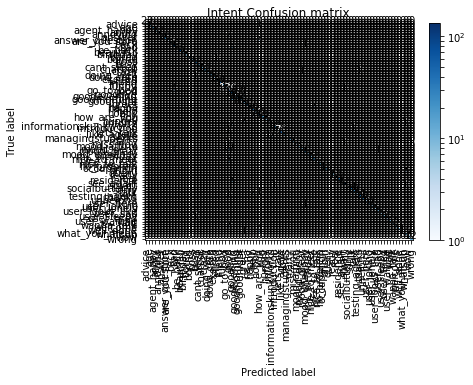

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9984050978092529
INFO:rasa_nlu.evaluate:Precision: 0.9986546268731988
INFO:rasa_nlu.evaluate:Accuracy:  0.9986528098537336
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

      group       1.00      0.46      0.63        13
  no_entity       1.00      1.00      1.00      5183

avg / total       1.00      1.00      1.00      5196



In [8]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# Part 2: Handling the dialogue

We have taught our chatbot how to understand user inputs. Now, it's time to teach our chatbot how to make responses by training a dialogue management model using Rasa Core.

### Writing Stories

The training data for dialogue management models is called `stories`. A story is an actual conversation where user inputs are expressed as intents as well as corresponding entities, and chatbot responses are expressed as actions.


Let's take a look into the format of the stories in more detail:

A story starts with `##` and you can give it a name. 
Lines that start with `*` are messages sent by the user. Although you don't write the *actual* message, but rather the intent (and the entities) that represent what the user *means*. 
Lines that start with `-` are *actions* taken by your bot. In this case all of our actions are just messages sent back to the user, like `utter_greet`, but in general an action can do anything, including calling an API and interacting with the outside world. 

stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - utter_ask_picture
* inform{"animal":"dog"}  
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - utter_ask_picture
* inform{"group":"cat"}
  - action_retrieve_image
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## sad path 3
* greet
  - utter_greet
* mood_unhappy{"group":"puppy"}
  - action_retrieve_image
  - utter_did_that_help
* mood_affirm
  - utter_happy
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

In [9]:
stories_md = """

## question path
* query
 - utter_answer
 
## social butterfly
* informationskunkworks
 -utter_skunk
 
## managing students
* managingstudents
 -utter_students
 
## social butterfly
* socialbutterfly
 -utter_social
 

 

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Defining a Domain

The domain specifies the universe that the bot operates in. In chatbot's world this universe consists of intents and entities as well as the actions which appear in training stories. The domain can also contain the templates for the answers a chabot should use to respond to the user and slots which will help the chatbot to keep track of the context. Let's look into the domain of our bot:

In [10]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy
- inform
- query
- answer
- informationskunkworks
- managingstudents
- socialbutterfly

slots:
  group:
    type: text
    
entities:
- group

actions:
- utter_greet
- utter_answer
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- utter_ask_picture
- utter_social
- utter_skunk
- utter_students
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
  
  utter_answer:
  - text: "This is a good subject ML"
  
  utter_ask_picture:
  - text: "To cheer you up, I can show you a cute picture of a dog, cat or a bird. Which one do you choose?"
  
  utter_skunk:
  - text: "NEU AI Skunkworks is a group of people who research and develop Artificial Intelligence, Machine Learning, and Deep Learning projects."
  
  utter_students:
  - text: "Managed by Tej, Raj and Vivek"
  
  utter_social:
  - text: "This is social butterfly"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Adding Custom Actions

The responses of the chatbot can be more than just simple text responses - we can call an API to retrieve some data which can later be used to create a response to user input. Let's create a custom action for our bot which, when predicted, will make an API and retrieve a picture of a dog, a cat or a bird, depending on which was specified by the user. The bot will know which type of picture should be received by retrieving the value of the slot `group`.


In [11]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet
from IPython.core.display import Image, display

import requests

class ApiAction(Action):
    def name(self):
        return "action_retrieve_image"

    def run(self, dispatcher, tracker, domain):
        
        group = tracker.get_slot('group')
        
        r = requests.get('https://avatars3.githubusercontent.com/u/47832285?s=400&v=4'.format(group))
        response = r.content.decode()
        response = response.replace('["',"")
        response = response.replace('"]',"")
   
        
        #display(Image(response[0], height=550, width=520))
        dispatcher.utter_message("Here is something to cheer you up: {}".format(response))

### Pro Tip: Visualising the Training Data

You can visualise the stories to get a sense of how the conversations go. This is usually a good way to see if there are any stories which don't make sense


### Training your Dialogue Model

Now we are good to train the dialogue management model. We can specify what policies should be used to train it - in this case, the model is a neural network implemented in Keras which learns to predict which action to take next. We can also tweak the parameters of what percentage of training examples should be used for validation and how many epochs should be used for training.

In [12]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.1)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=200
)

agent.persist('models/dialogue')

INFO:apscheduler.scheduler:Scheduler started
Using TensorFlow backend.
Processed Story Blocks: 100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 95.78it/s, # trackers=20]
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|█████████████████████████████████████████████| 152/152 [00:03<00:00, 50.60it/s, # actions=169]
INFO:rasa_core.featurizers:Created 169 action examples.
Processed actions: 169it [00:00, 400.00it/s, # examples=169]
INFO:rasa_core.policies.memoization:Memorized 169 unique action examples.
INFO:rasa_core.featurizers:Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|█████████████████████████████████████████████| 152/152 [00:02<00:00, 55.12it/s, # actions=169]
INFO:rasa_core.featurizers:Created 169 action examples.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5, 27)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                7680      
_________________________________________________________________
dense_1 (Dense)              (None, 13)                429       
_________________________________________________________________
activation_1 (Activation)    (None, 13)                0         
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


INFO:rasa_core.policies.keras_policy:Fitting model with 169 total samples and a validation split of 0.0


Epoch 1/200
169/169 [==============================] - ETA: 4s - loss: 2.5082 - acc: 0.156 - 1s 6ms/step - loss: 2.4686 - acc: 0.3491
Epoch 2/200
169/169 [==============================] - ETA: 0s - loss: 2.3878 - acc: 0.468 - 0s 271us/step - loss: 2.3679 - acc: 0.4556
Epoch 3/200
169/169 [==============================] - ETA: 0s - loss: 2.3546 - acc: 0.375 - 0s 179us/step - loss: 2.2690 - acc: 0.5030
Epoch 4/200
169/169 [==============================] - ETA: 0s - loss: 2.2000 - acc: 0.531 - 0s 207us/step - loss: 2.1529 - acc: 0.5089
Epoch 5/200
169/169 [==============================] - ETA: 0s - loss: 2.1315 - acc: 0.468 - 0s 218us/step - loss: 2.0195 - acc: 0.5089
Epoch 6/200
169/169 [==============================] - ETA: 0s - loss: 1.8692 - acc: 0.562 - 0s 212us/step - loss: 1.8647 - acc: 0.5030
Epoch 7/200
169/169 [==============================] - ETA: 0s - loss: 1.8028 - acc: 0.500 - 0s 242us/step - loss: 1.7362 - acc: 0.5030
Epoch 8/200
169/169 [=============================

Epoch 61/200
169/169 [==============================] - ETA: 0s - loss: 0.5917 - acc: 0.968 - 0s 195us/step - loss: 0.4930 - acc: 0.9704
Epoch 62/200
169/169 [==============================] - ETA: 0s - loss: 0.4739 - acc: 1.000 - 0s 212us/step - loss: 0.4465 - acc: 0.9763
Epoch 63/200
169/169 [==============================] - ETA: 0s - loss: 0.3275 - acc: 1.000 - 0s 195us/step - loss: 0.4624 - acc: 0.9822
Epoch 64/200
169/169 [==============================] - ETA: 0s - loss: 0.3616 - acc: 1.000 - 0s 190us/step - loss: 0.4597 - acc: 0.9586
Epoch 65/200
169/169 [==============================] - ETA: 0s - loss: 0.4575 - acc: 1.000 - 0s 218us/step - loss: 0.4396 - acc: 0.9882
Epoch 66/200
169/169 [==============================] - ETA: 0s - loss: 0.4317 - acc: 0.968 - 0s 201us/step - loss: 0.4320 - acc: 0.9882
Epoch 67/200
169/169 [==============================] - ETA: 0s - loss: 0.3637 - acc: 1.000 - 0s 206us/step - loss: 0.4100 - acc: 0.9882
Epoch 68/200
169/169 [===================

169/169 [==============================] - ETA: 0s - loss: 0.1446 - acc: 1.000 - 0s 236us/step - loss: 0.1306 - acc: 0.9822
Epoch 121/200
169/169 [==============================] - ETA: 0s - loss: 0.1193 - acc: 1.000 - 0s 200us/step - loss: 0.1122 - acc: 0.9941
Epoch 122/200
169/169 [==============================] - ETA: 0s - loss: 0.0937 - acc: 1.000 - 0s 225us/step - loss: 0.1194 - acc: 0.9822
Epoch 123/200
169/169 [==============================] - ETA: 0s - loss: 0.0697 - acc: 1.000 - 0s 241us/step - loss: 0.1174 - acc: 0.9941
Epoch 124/200
169/169 [==============================] - ETA: 0s - loss: 0.0928 - acc: 0.968 - 0s 219us/step - loss: 0.0939 - acc: 0.9941
Epoch 125/200
169/169 [==============================] - ETA: 0s - loss: 0.1058 - acc: 1.000 - 0s 224us/step - loss: 0.1066 - acc: 1.0000
Epoch 126/200
169/169 [==============================] - ETA: 0s - loss: 0.1084 - acc: 1.000 - 0s 207us/step - loss: 0.1033 - acc: 1.0000
Epoch 127/200
169/169 [=========================

169/169 [==============================] - ETA: 0s - loss: 0.0798 - acc: 1.000 - 0s 242us/step - loss: 0.0628 - acc: 0.9941
Epoch 180/200
169/169 [==============================] - ETA: 0s - loss: 0.0193 - acc: 1.000 - 0s 211us/step - loss: 0.0552 - acc: 0.9882
Epoch 181/200
169/169 [==============================] - ETA: 0s - loss: 0.0812 - acc: 1.000 - 0s 212us/step - loss: 0.0315 - acc: 1.0000
Epoch 182/200
169/169 [==============================] - ETA: 0s - loss: 0.0904 - acc: 1.000 - 0s 207us/step - loss: 0.0376 - acc: 1.0000
Epoch 183/200
169/169 [==============================] - ETA: 0s - loss: 0.0218 - acc: 1.000 - 0s 221us/step - loss: 0.0414 - acc: 1.0000
Epoch 184/200
169/169 [==============================] - ETA: 0s - loss: 0.0365 - acc: 1.000 - 0s 194us/step - loss: 0.0467 - acc: 1.0000
Epoch 185/200
169/169 [==============================] - ETA: 0s - loss: 0.0415 - acc: 1.000 - 0s 201us/step - loss: 0.0347 - acc: 1.0000
Epoch 186/200
169/169 [=========================

INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to 'c:\Python\rasa-workshop-pydata-berlin-master\models\dialogue'


### Starting up the bot (with NLU)

Now it's time for the fun part - starting the agent and chatting with it. We are going to start the `Agent` by loading our just trained dialogue model and using the previously trained nlu model as an interpreter for incoming user inputs.

In [13]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Talking to the Bot (with NLU)

Let's have a chat!

In [ ]:
print("Your bot is ready to talk! Type your messages here or send 'stop'")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Your bot is ready to talk! Type your messages here or send 'stop'
hey
This is social butterfly
skunksworks
This is social butterfly


### Evaluation of the dialogue model
As with the NLU model, instead of just subjectively testing the model, we can also evaluate the model on a dataset. You'll be using the training data set again, but usually you'd use a test data set separate from the training data.

In [ ]:
<javascript>

Processed Story Blocks: 100%|██████████| 7/7 [00:00<00:00, 42003.04it/s]
INFO:rasa_core.evaluate:Evaluating 7 stories
Progress:
100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

        action_listen       1.00      1.00      1.00        18
action_retrieve_image       1.00      1.00      1.00         3
    utter_ask_picture       1.00      1.00      1.00         2
  utter_did_that_help       1.00      1.00      1.00         3
        utter_goodbye       1.00      1.00      1.00         3
          utter_greet       1.00      1.00      1.00         4
          utter_happy       1.00      1.00      1.00         5
        utter_unclear       1.00      1.00      1.00         1

          avg / total       1.00      1.00      1.00        39

INFO:rasa_nlu.evaluate:Confusion

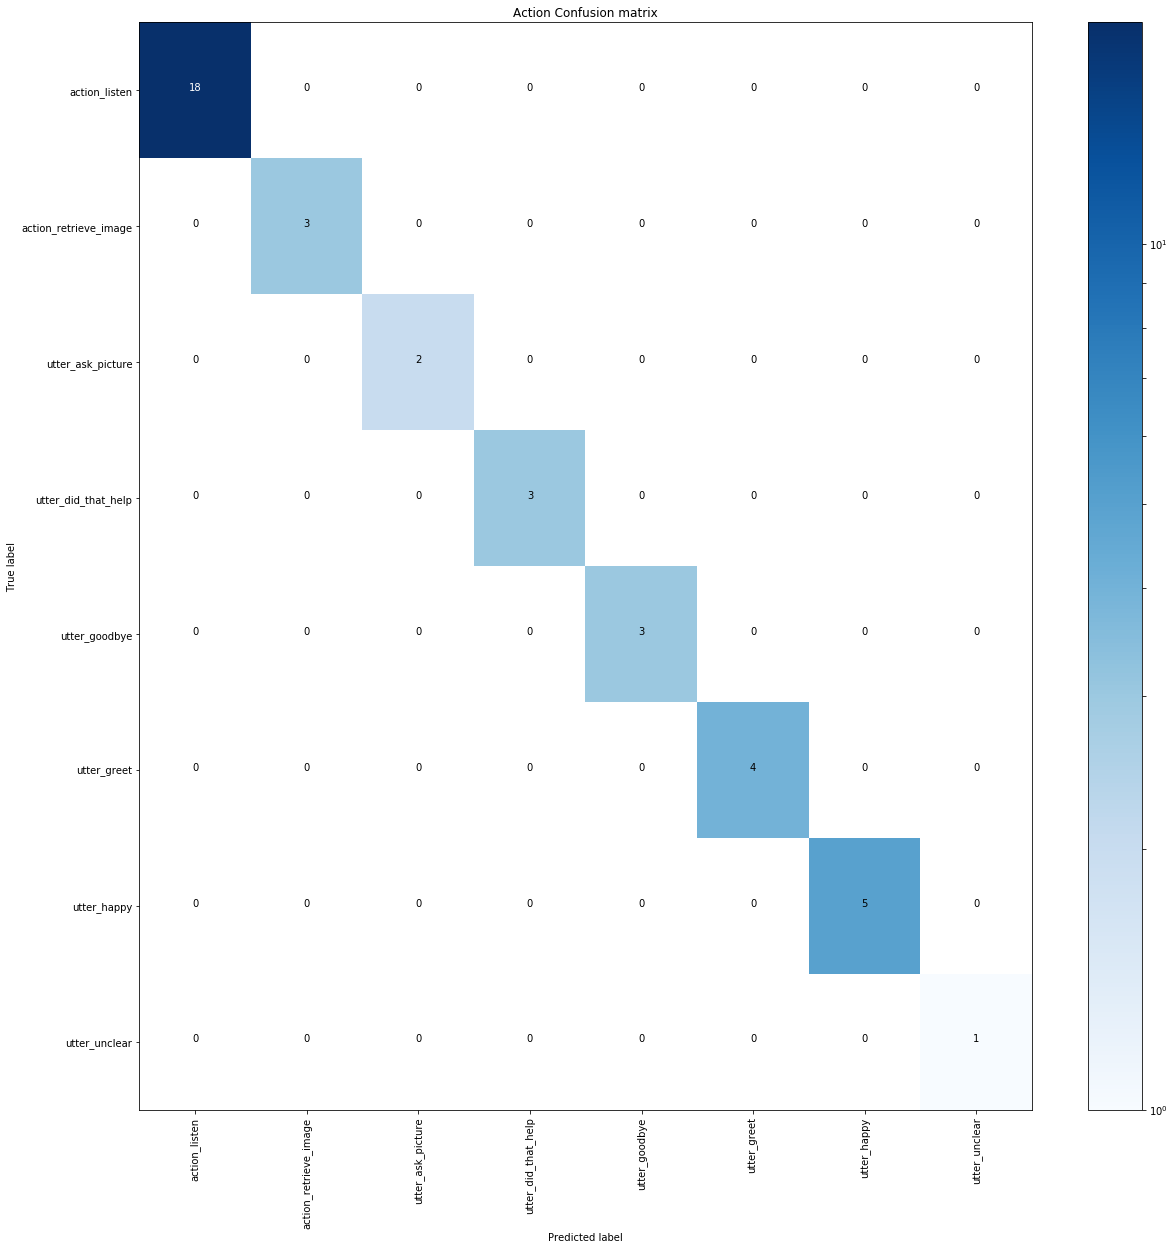

In [73]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")

### Interactive learning
Unfortunately, this doesn't work in Jupyter yet. Hence, we going to do this on the command line. To start the interactive training session open your command line and run `train_online.py` script.

### Resources and tips

- Rasa NLU [documentation](https://nlu.rasa.com/)
- Rasa Core [documentation](https://core.rasa.com/)
- Rasa Community on [Gitter](https://gitter.im/RasaHQ/home)
- Rasa [Blog](https://blog.rasa.com/)